<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-11-21 17:00:00+09:00,730,0,539,2020-11-21 17:00:00+09:00
2020-11-22 17:00:00+09:00,622,0,391,2020-11-22 17:00:00+09:00
2020-11-23 17:00:00+09:00,663,0,314,2020-11-23 17:00:00+09:00
2020-11-24 17:00:00+09:00,556,0,186,2020-11-24 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-11-21 17:00:00+09:00,730,0,539,2020-11-21 17:00:00+09:00,530.285714,3712.0,0.0,0.0,401.714286,2812.0
2020-11-22 17:00:00+09:00,622,0,391,2020-11-22 17:00:00+09:00,563.285714,3943.0,0.0,0.0,421.142857,2948.0
2020-11-23 17:00:00+09:00,663,0,314,2020-11-23 17:00:00+09:00,588.714286,4121.0,0.0,0.0,440.285714,3082.0
2020-11-24 17:00:00+09:00,556,0,186,2020-11-24 17:00:00+09:00,612.285714,4286.0,0.0,0.0,424.285714,2970.0
2020-11-25 17:00:00+09:00,0,0,401,2020-11-25 17:00:00+09:00,534.285714,3740.0,0.0,0.0,412.285714,2886.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-11-11 17:00:00+09:00,373,0,316,2020-11-11 17:00:00+09:00,373.000000,2611.0,0.0,0.0,251.428571,1760.0,'20w46,Wed
2020-11-12 17:00:00+09:00,380,0,392,2020-11-12 17:00:00+09:00,380.000000,2660.0,0.0,0.0,269.000000,1883.0,'20w46,Thu
2020-11-13 17:00:00+09:00,497,0,374,2020-11-13 17:00:00+09:00,399.142857,2794.0,0.0,0.0,287.857143,2015.0,'20w46,Fri
2020-11-14 17:00:00+09:00,395,0,352,2020-11-14 17:00:00+09:00,387.000000,2709.0,0.0,0.0,296.142857,2073.0,'20w46,Sat
2020-11-15 17:00:00+09:00,391,0,255,2020-11-15 17:00:00+09:00,388.285714,2718.0,0.0,0.0,305.571429,2139.0,'20w46,Sun
2020-11-16 17:00:00+09:00,485,0,180,2020-11-16 17:00:00+09:00,404.428571,2831.0,0.0,0.0,308.857143,2162.0,'20w47,Mon
2020-11-17 17:00:00+09:00,391,0,298,2020-11-17 17:00:00+09:00,416.000000,2912.0,0.0,0.0,309.571429,2167.0,'20w47,Tue
2020-11-18 17:00:00+09:00,546,0,485,2020-11-18 17:00:00+09:00,440.714286,3085.0,0.0,0.0,333.714286,2336.0,'20w47,Wed
2020-11-19 17:00:00+09:00,561,0,533,2020-11-19 17:00:00+09:00,466.571429,3266.0,0.0,0.0,353.857143,2477.0,'20w47,Thu
2020-11-20 17:00:00+09:00,608,0,522,2020-11-20 17:00:00+09:00,482.428571,3377.0,0.0,0.0,375.000000,2625.0,'20w47,Fri


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-11-01 17:00:00+09:00,169.285714,1185
2020-11-08 17:00:00+09:00,201.714286,1412
2020-11-15 17:00:00+09:00,305.571429,2139
2020-11-22 17:00:00+09:00,421.142857,2948
2020-11-25 17:00:00+09:00,300.333333,901


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-11-11 17:00:00+09:00,373,0,316,2020-11-11 17:00:00+09:00,373.000000,2611.0,0.0,0.0,251.428571,1760.0,'20w46,Wed,NaN,NaN
2020-11-12 17:00:00+09:00,380,0,392,2020-11-12 17:00:00+09:00,380.000000,2660.0,0.0,0.0,269.000000,1883.0,'20w46,Thu,NaN,NaN
2020-11-13 17:00:00+09:00,497,0,374,2020-11-13 17:00:00+09:00,399.142857,2794.0,0.0,0.0,287.857143,2015.0,'20w46,Fri,NaN,NaN
2020-11-14 17:00:00+09:00,395,0,352,2020-11-14 17:00:00+09:00,387.000000,2709.0,0.0,0.0,296.142857,2073.0,'20w46,Sat,NaN,NaN
2020-11-15 17:00:00+09:00,391,0,255,2020-11-15 17:00:00+09:00,388.285714,2718.0,0.0,0.0,305.571429,2139.0,'20w46,Sun,305.571429,2139.0
2020-11-16 17:00:00+09:00,485,0,180,2020-11-16 17:00:00+09:00,404.428571,2831.0,0.0,0.0,308.857143,2162.0,'20w47,Mon,NaN,NaN
2020-11-17 17:00:00+09:00,391,0,298,2020-11-17 17:00:00+09:00,416.000000,2912.0,0.0,0.0,309.571429,2167.0,'20w47,Tue,NaN,NaN
2020-11-18 17:00:00+09:00,546,0,485,2020-11-18 17:00:00+09:00,440.714286,3085.0,0.0,0.0,333.714286,2336.0,'20w47,Wed,NaN,NaN
2020-11-19 17:00:00+09:00,561,0,533,2020-11-19 17:00:00+09:00,466.571429,3266.0,0.0,0.0,353.857143,2477.0,'20w47,Thu,NaN,NaN
2020-11-20 17:00:00+09:00,608,0,522,2020-11-20 17:00:00+09:00,482.428571,3377.0,0.0,0.0,375.000000,2625.0,'20w47,Fri,NaN,NaN


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

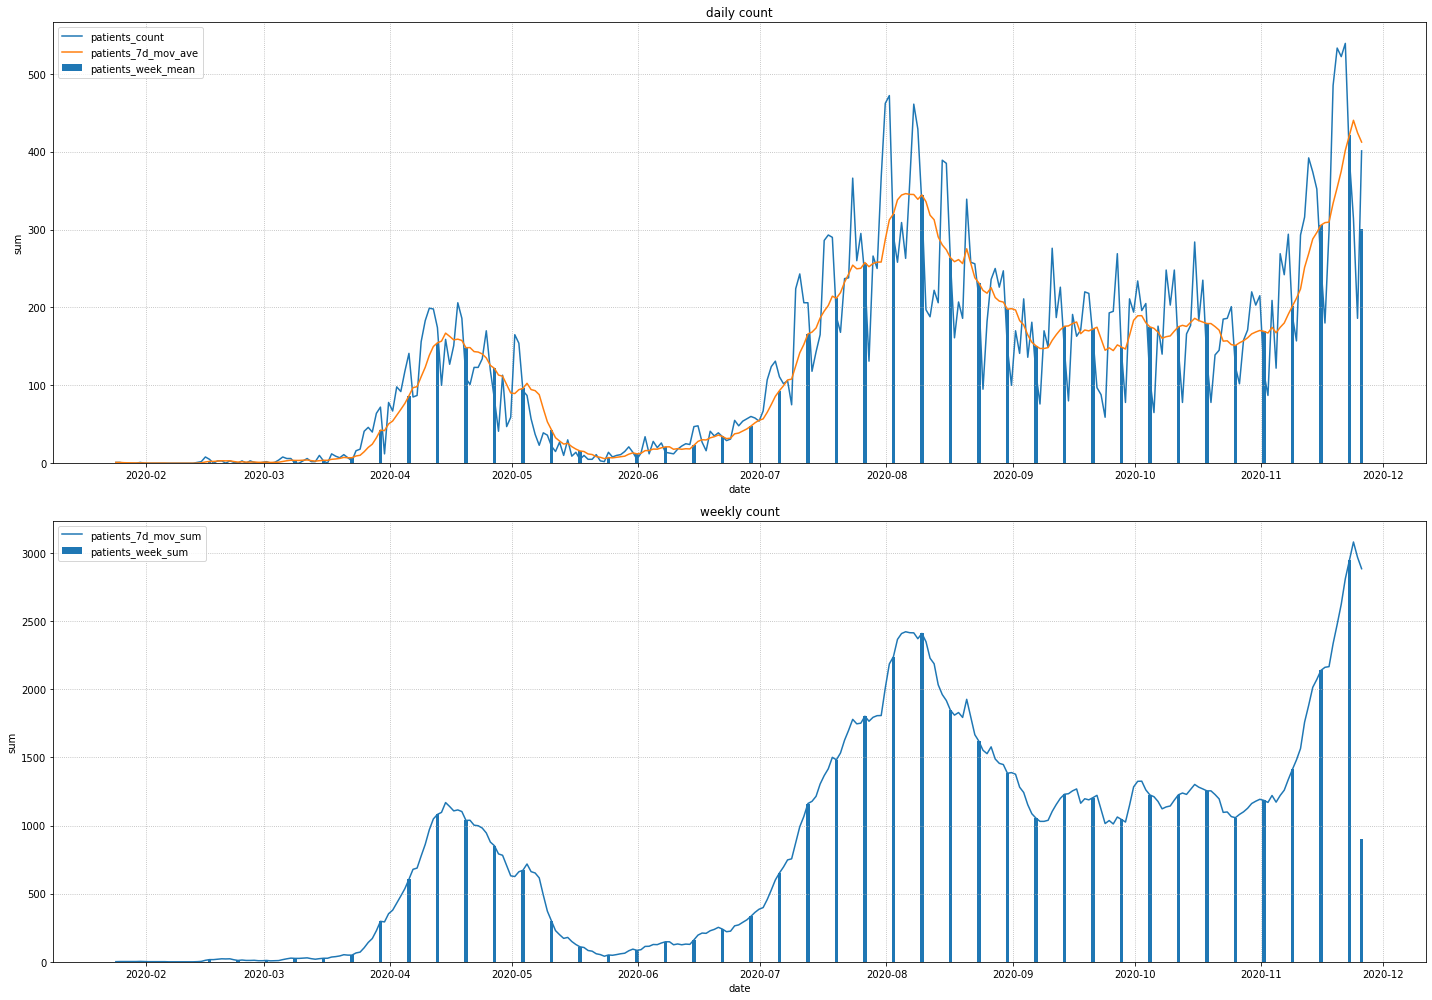

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
292,1.605082e+09,2020,11,11,0,0,0,0,0,0,1,292,0,218,373,373.000000,2611.0,0,0.0,0.0,316,251.428571,1760.0
293,1.605168e+09,2020,11,12,0,0,0,0,1,0,0,293,0,219,380,380.000000,2660.0,0,0.0,0.0,392,269.000000,1883.0
294,1.605254e+09,2020,11,13,1,0,0,0,0,0,0,294,0,220,497,399.142857,2794.0,0,0.0,0.0,374,287.857143,2015.0
295,1.605341e+09,2020,11,14,0,0,1,0,0,0,0,295,0,221,395,387.000000,2709.0,0,0.0,0.0,352,296.142857,2073.0
296,1.605427e+09,2020,11,15,0,0,0,1,0,0,0,296,0,222,391,388.285714,2718.0,0,0.0,0.0,255,305.571429,2139.0
297,1.605514e+09,2020,11,16,0,1,0,0,0,0,0,297,0,223,485,404.428571,2831.0,0,0.0,0.0,180,308.857143,2162.0
298,1.605600e+09,2020,11,17,0,0,0,0,0,1,0,298,0,224,391,416.000000,2912.0,0,0.0,0.0,298,309.571429,2167.0
299,1.605686e+09,2020,11,18,0,0,0,0,0,0,1,299,0,225,546,440.714286,3085.0,0,0.0,0.0,485,333.714286,2336.0
300,1.605773e+09,2020,11,19,0,0,0,0,1,0,0,300,0,226,561,466.571429,3266.0,0,0.0,0.0,533,353.857143,2477.0
301,1.605859e+09,2020,11,20,1,0,0,0,0,0,0,301,0,227,608,482.428571,3377.0,0,0.0,0.0,522,375.000000,2625.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307 entries, 0 to 306
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            307 non-null    float64
 1   year                 307 non-null    int64  
 2   month                307 non-null    int64  
 3   day                  307 non-null    int64  
 4   Fri                  307 non-null    uint8  
 5   Mon                  307 non-null    uint8  
 6   Sat                  307 non-null    uint8  
 7   Sun                  307 non-null    uint8  
 8   Thu                  307 non-null    uint8  
 9   Tue                  307 non-null    uint8  
 10  Wed                  307 non-null    uint8  
 11  passed               307 non-null    int64  
 12  emergency            307 non-null    int64  
 13  em_passed            307 non-null    int64  
 14  contacts_count       307 non-null    int64  
 15  contacts_7d_mov_ave  307 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,3.070000e+02,307.0,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.00000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,1.593072e+09,2020.0,6.299674,15.814332,0.143322,0.143322,0.143322,0.143322,0.140065,0.143322,0.143322,153.000000,0.159609,88.039088,761.358306,757.001784,5299.00000,1197.807818,1197.807818,8384.654723,125.726384,122.306794,856.094463
std,7.669511e+06,0.0,2.921875,8.826286,0.350973,0.350973,0.350973,0.350973,0.347621,0.350973,0.350973,88.767487,0.366841,76.905415,483.909192,471.698140,3301.90699,825.434415,662.349797,4636.448579,120.255760,107.857648,755.063669
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.586462e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,76.500000,0.000000,2.500000,445.000000,452.857143,3170.00000,441.000000,907.642857,6353.500000,13.500000,15.357143,107.500000
50%,1.593072e+09,2020.0,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,153.000000,0.000000,79.000000,608.000000,616.142857,4313.00000,1236.000000,1205.142857,8436.000000,102.000000,135.142857,946.000000
75%,1.599682e+09,2020.0,9.000000,23.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.500000,0.000000,155.500000,934.000000,929.642857,6507.50000,1766.000000,1663.000000,11641.000000,200.000000,180.571429,1264.000000
max,1.606291e+09,2020.0,11.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,306.000000,1.000000,232.000000,2265.000000,2096.857143,14678.00000,4060.000000,2574.142857,18019.000000,539.000000,440.285714,3082.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,NaN,0.995080,0.008121,-0.011538,0.002308,-0.006923,-0.002308,-3.139333e-18,0.006923,0.011538,1.000000e+00,-0.270461,0.983321,-0.071875,-0.035231,-0.035225,0.097340,0.182624,0.182624,0.697518,0.761235,0.761295
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,9.950804e-01,NaN,1.000000,-0.090847,-0.013339,0.002595,-0.006965,-0.000592,3.668093e-04,0.005782,0.012155,9.950804e-01,-0.267337,0.977367,-0.067187,-0.032118,-0.032111,0.099178,0.186791,0.186791,0.695780,0.757694,0.757762
day,8.121058e-03,NaN,-0.090847,1.000000,0.019168,-0.002986,0.000179,-0.016700,-3.212676e-03,0.010728,-0.007206,8.121058e-03,-0.005957,0.012557,-0.020169,-0.004053,-0.004058,-0.001936,-0.024172,-0.024172,-0.011739,0.002988,0.002912
Fri,-1.153833e-02,NaN,-0.013339,0.019168,1.000000,-0.167300,-0.167300,-0.167300,-1.650748e-01,-0.167300,-0.167300,-1.153833e-02,-0.000579,-0.009531,-0.015312,-0.005613,-0.005612,0.051962,-0.002406,-0.002406,0.087806,-0.011068,-0.011113
Mon,2.307666e-03,NaN,0.002595,-0.002986,-0.167300,1.000000,-0.167300,-0.167300,-1.650748e-01,-0.167300,-0.167300,2.307666e-03,-0.000579,0.002455,0.050918,0.000069,0.000070,0.242713,-0.002406,-0.002406,-0.168093,0.004218,0.004228
Sat,-6.922999e-03,NaN,-0.006965,0.000179,-0.167300,-0.167300,1.000000,-0.167300,-1.650748e-01,-0.167300,-0.167300,-6.922999e-03,-0.000579,-0.005535,0.037506,-0.003555,-0.003553,-0.281574,-0.002406,-0.002406,0.112041,-0.004433,-0.004466
Sun,-2.307666e-03,NaN,-0.000592,-0.016700,-0.167300,-0.167300,-0.167300,1.000000,-1.650748e-01,-0.167300,-0.167300,-2.307666e-03,-0.000579,-0.001540,-0.011290,-0.001801,-0.001799,-0.259476,-0.002406,-0.002406,-0.048932,0.000360,0.000356
Thu,-3.139333e-18,NaN,0.000367,-0.003213,-0.165075,-0.165075,-0.165075,-0.165075,1.000000e+00,-0.165075,-0.165075,-3.762518e-19,0.003506,-0.002895,-0.004709,0.007689,0.007690,0.084670,0.014572,0.014572,0.095668,-0.007089,-0.007060
Tue,6.922999e-03,NaN,0.005782,0.010728,-0.167300,-0.167300,-0.167300,-0.167300,-1.650748e-01,1.000000,-0.167300,6.922999e-03,-0.000579,0.006451,-0.029204,0.001637,0.001638,0.096441,-0.002406,-0.002406,-0.045292,0.006503,0.006522


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,1.605946e+09,0,0,1,0,0,0,0,302,0,228,730,0,539,401.714286,2812.0
303,1.606032e+09,0,0,0,1,0,0,0,303,0,229,622,0,391,421.142857,2948.0
304,1.606118e+09,0,1,0,0,0,0,0,304,0,230,663,0,314,440.285714,3082.0
305,1.606205e+09,0,0,0,0,0,1,0,305,0,231,556,0,186,424.285714,2970.0


In [26]:
import seaborn as sns

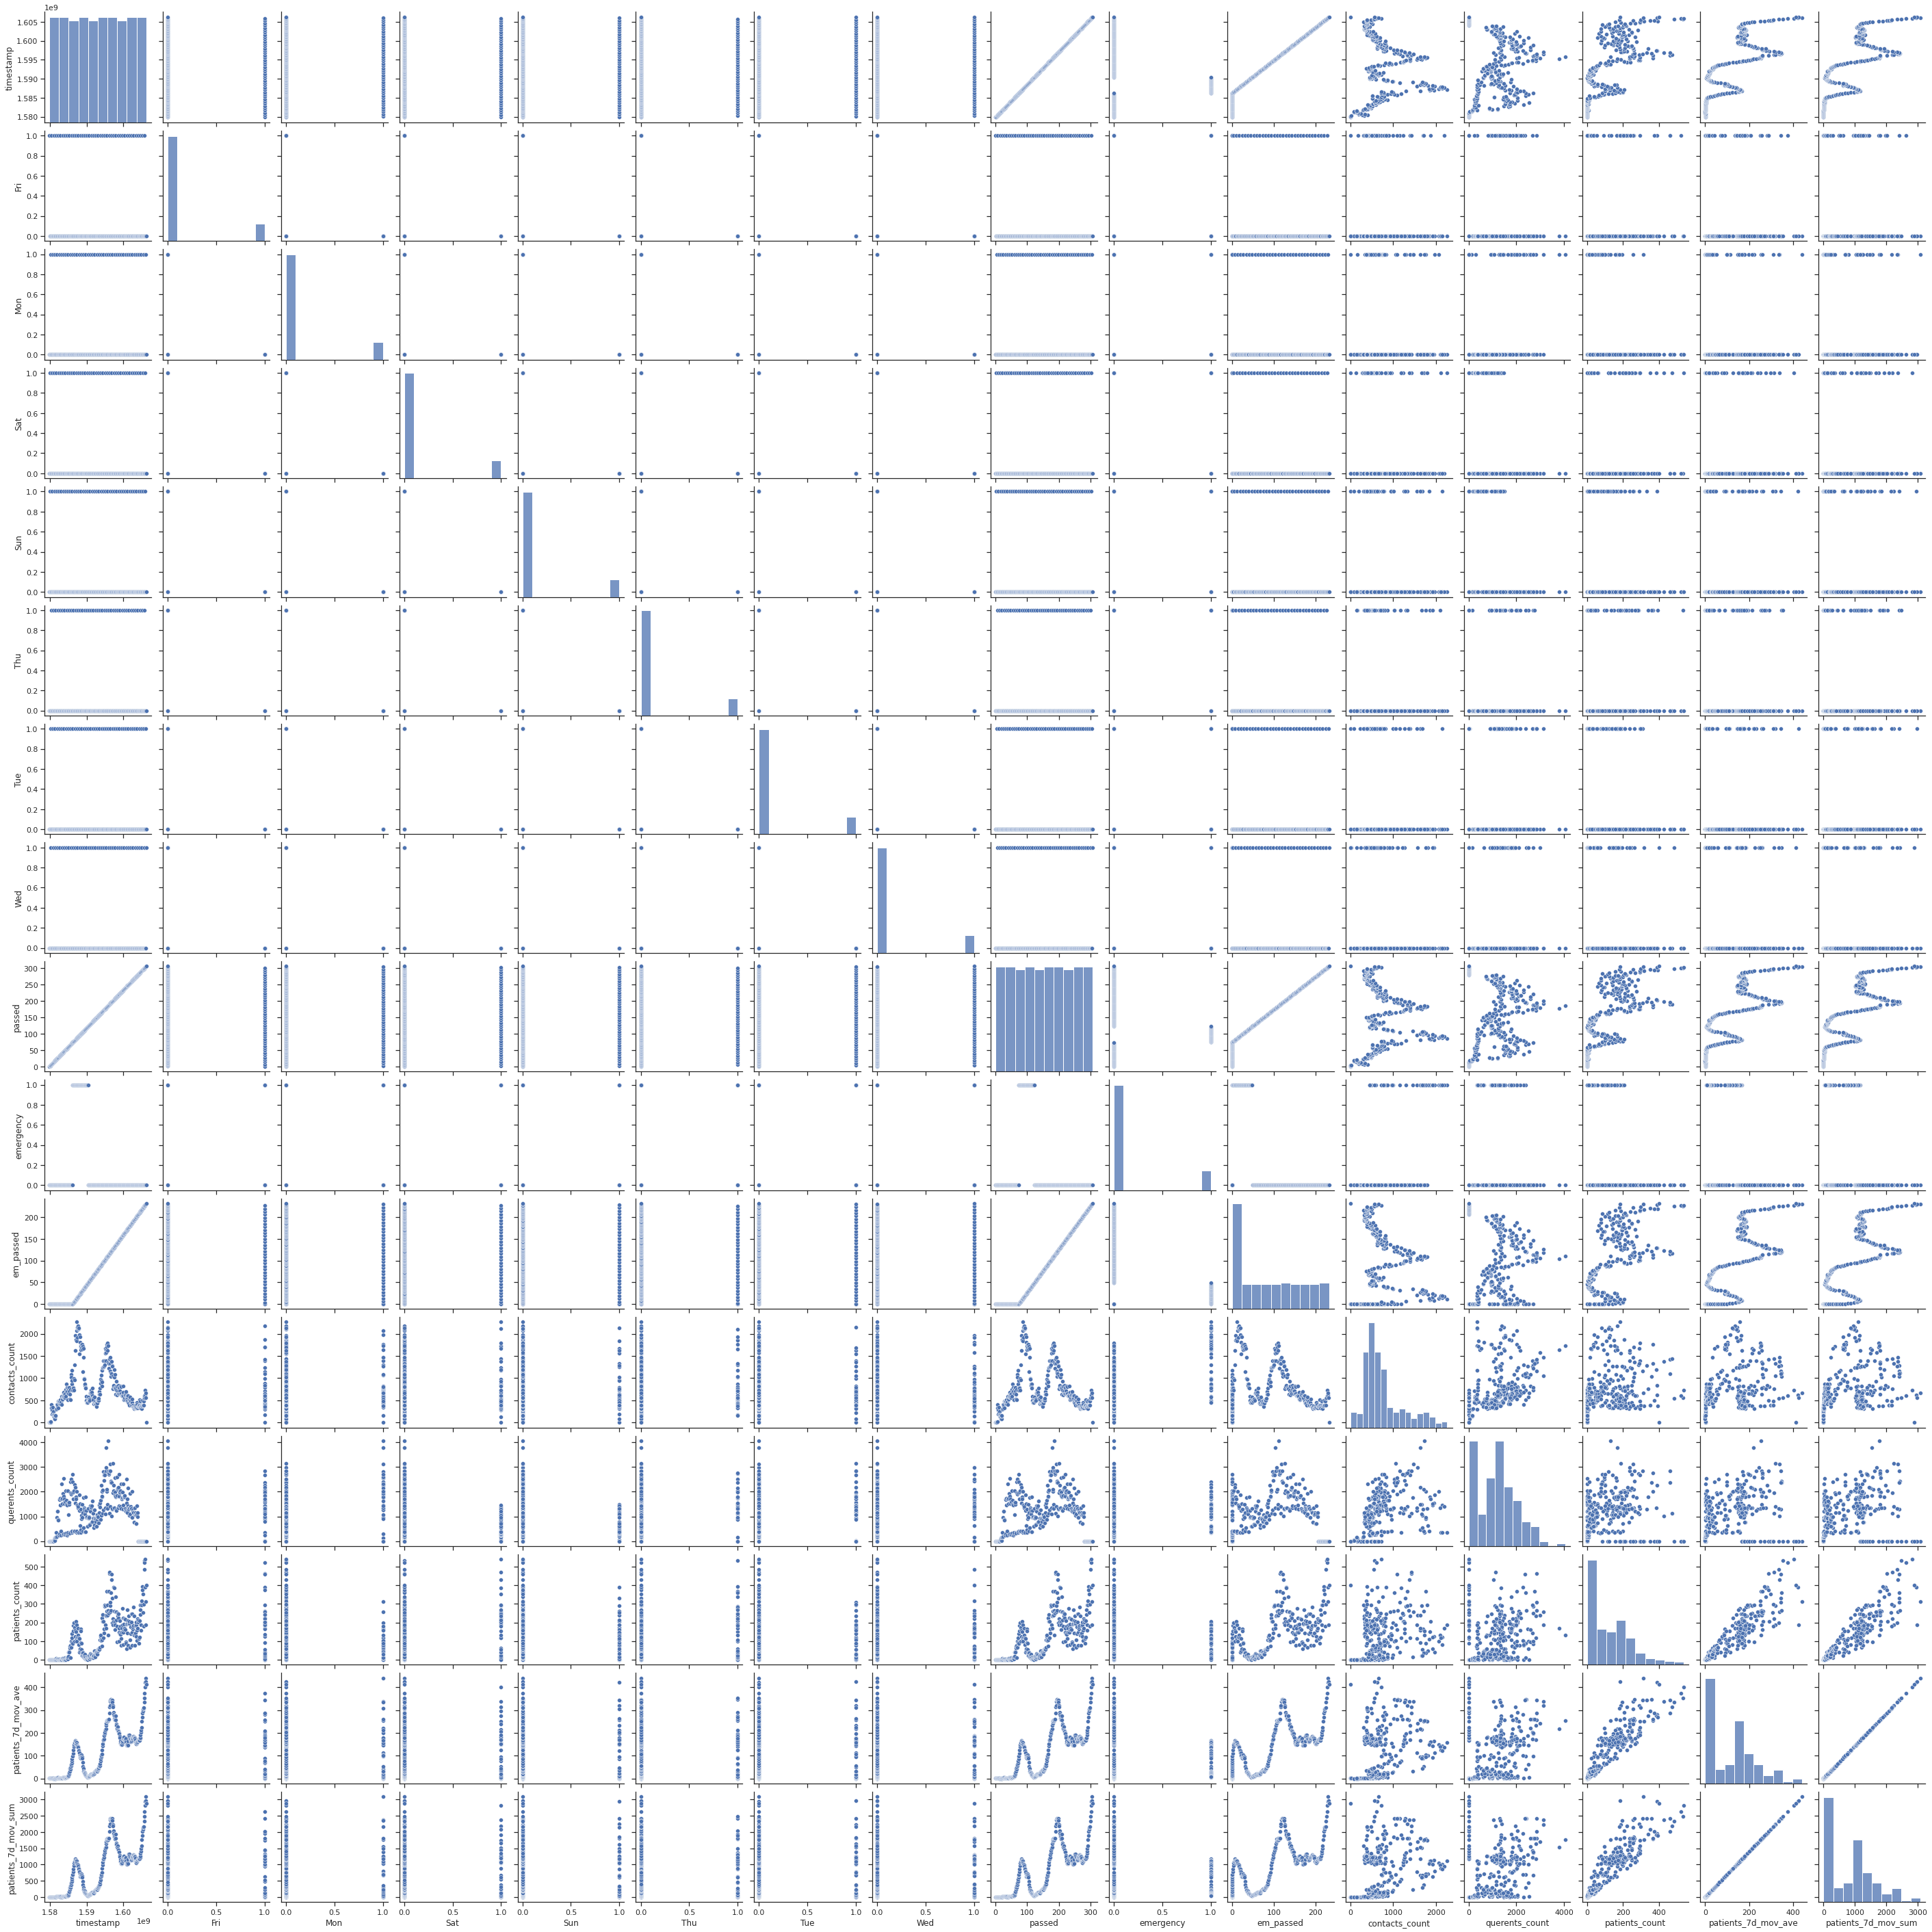

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
